In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [69]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")


# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0], Dataset_std.shape[0]/2, random_state=22)
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])


# Checking distribution before and after shortening
print("Original Dataset Shape: ", Dataset_std.shape)
print("Reduced Dataset Shape: ", Dataset_std_short.shape)

Original Dataset Shape:  (157800, 36)
Reduced Dataset Shape:  (78900, 36)


In [70]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_norm_short, Attack_label_short)
print("Target Shape: ", Attack_label_short.shape)
print("Resampled Target Shape: ", Target_res.shape)

print(Attack_label_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Target Shape:  (78900, 1)
Resampled Target Shape:  (105879, 1)
Attack_label
1               0.845982
0               0.154018
Name: proportion, dtype: float64
Attack_label
1               0.517326
0               0.482674
Name: proportion, dtype: float64


In [71]:
# seperating Datasamples with normal and abnormal samples
Dataset_only0 = Dataset_res.loc[Target_res['Attack_label'] == 0] # normal label
Dataset_only1 = Dataset_res.loc[Target_res['Attack_label'] == 1] 
print("Sample shape of only normal label", Dataset_only0.shape)
print("Sample shape of only abnormal label", Dataset_only1.shape)

from sklearn.model_selection import train_test_split
X_train, array_test_0 = train_test_split(Dataset_only0, train_size=0.5, random_state=22)

Sample shape of only normal label (51105, 36)
Sample shape of only abnormal label (54774, 36)


* X_train is dataframe of only normal samples

In [72]:
# preparing the test dataset by joining some of the normal and abnormal samples.
import numpy as np

array1 = Dataset_only1.to_numpy() 

# Joining the abnormal and normal samples for testing
X_test = np.concatenate((array1, array_test_0), axis=0)
Y_test = np.concatenate((np.ones(array1.shape[0])*-1, np.ones(array_test_0.shape[0])), axis=0)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (25552, 36)
Shape of X_test:  (80327, 36)


* X_test is array of both normal and abnormal samples with huge proportion of abnormal instances.<br>
Y_test is label of 1 and -1 for the normal and abnormal instances respectively.  


In [73]:
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.95, random_state=22)
print("Shape of X_val: ", X_val.shape)

Shape of X_val:  (4016, 36)


## Determining Hyperparameter

Gridsearch

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

parameters = {'n_neighbors': [6, 10, 20], 'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'l1', 'l2', 'minkowski']}

lof = LocalOutlierFactor(novelty=True)

# Scoring function
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = f1_score(y, y_pred, pos_label=-1)
    roc = roc_auc_score(y, y_pred)
    # Composite score
    score = f1 + roc - (fp + fn)
    return score

# Set up the GridSearchCV
grid_search = GridSearchCV(lof, parameters, scoring= custom_scorer, cv=4, refit= True)

# fitting grid search
grid_search.fit(X_val, Y_val)

print('Best parameters: ',  grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 6}
Best score:  -543.4011738090182


## LOF for Novelty Detection

Novelty detection is semisupervised Outlier Detection because it uses only Normal Dataset to train.(supervised learning aspect)<br>
and during testing phase unlabeled Data are given to predict whether it is novelty/anomalie or not.<br>
Novelties/anomalies can form a dense cluster as long as they are in a low density region of the training data, which is only normal.

In [48]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=6, novelty=True, metric= 'euclidean', leaf_size=20)
lof.fit(X_train)
Y_pred = lof.predict(X_test)

### Evaluation

Average Accuracy Score: 0.9003232287935704
Balanced Accuracy Score: 0.8812769160998231
         Precision    Recall  F1-Score
Anomaly   0.921918  0.933191   0.92752


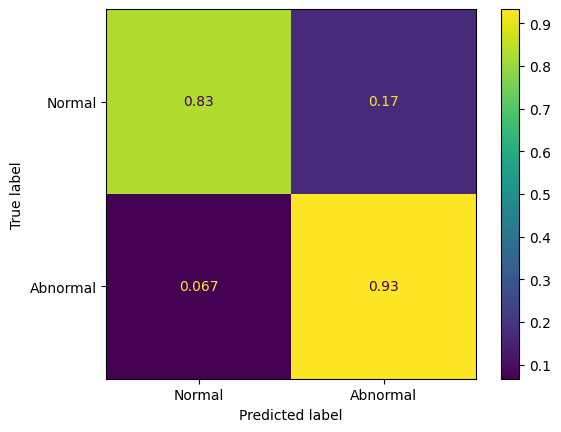

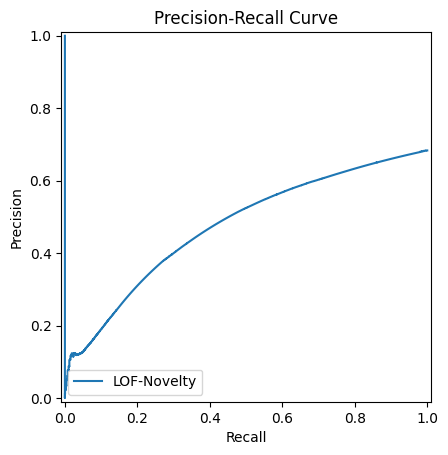

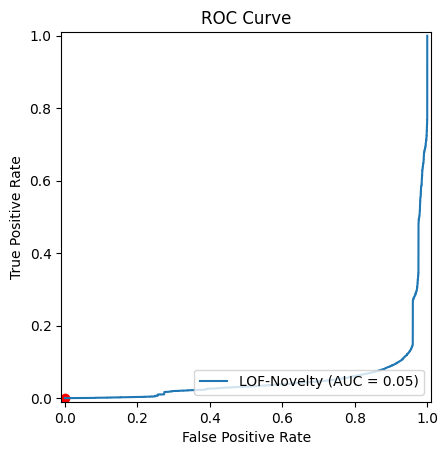

In [49]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, normalize= 'true', labels=[1, -1],  display_labels=['Normal', 'Abnormal'])

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# FOR Prec-Recall and ROC, decision function scores are needed (not just -1 or 1 labels)
Y_scores = lof.decision_function(X_test)

#Precision-Recall Curve
prec, recall, _ = metrics.precision_recall_curve(Y_test, Y_scores, pos_label= -1)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='LOF-Novelty').plot()
plt.title('Precision-Recall Curve')


fpr, tpr, _ = metrics.roc_curve(Y_test, Y_scores, pos_label= -1)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='LOF-Novelty')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()


## LOF for Novelty Detection after PCA

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

lof.fit(X_train_PCA)
Y_pred = lof.predict(X_test_PCA)

### Evaluation

Average Accuracy Score: 0.9003232287935704
Balanced Accuracy Score: 0.8911282806536602
         Precision    Recall  F1-Score
Anomaly   0.936583  0.916191  0.926275


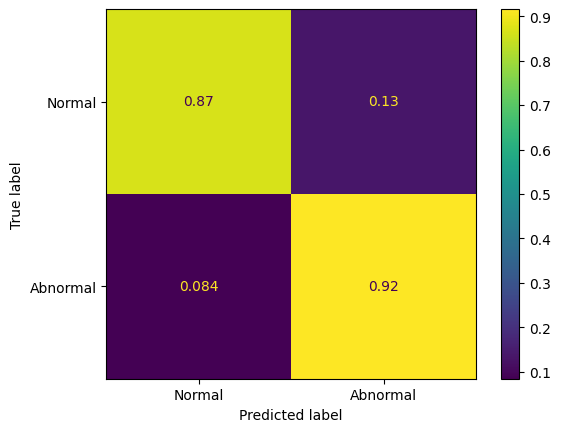

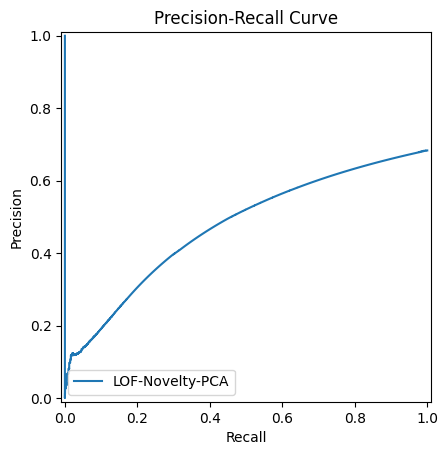

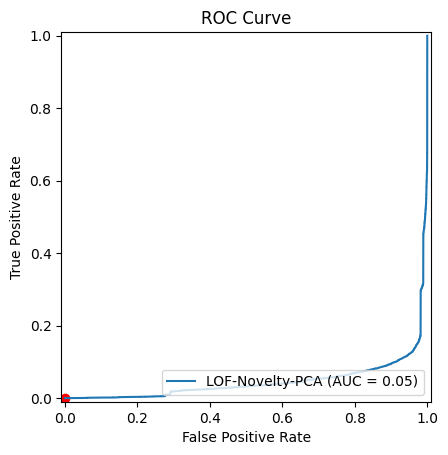

In [52]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, normalize= 'true', labels=[1, -1],  display_labels=['Normal', 'Abnormal'])

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)

# FOR Prec-Recall and ROC, decision function scores are needed (not just -1 or 1 labels)
Y_scores = lof.decision_function(X_test_PCA)

#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_scores, pos_label= -1)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='LOF-Novelty-PCA').plot()
plt.title('Precision-Recall Curve')

fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_scores, pos_label= -1)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name= 'LOF-Novelty-PCA')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()


### Visualisation

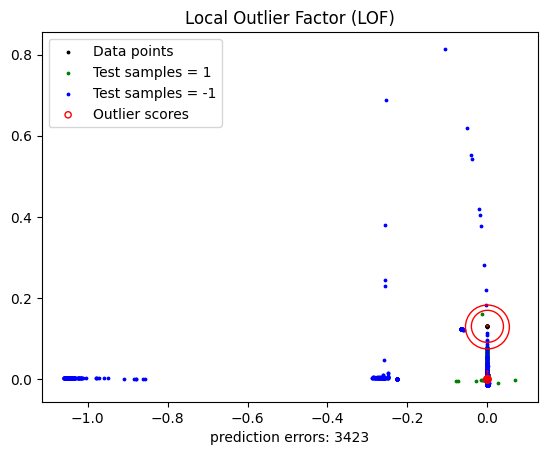

In [53]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])

X_scores = lof.negative_outlier_factor_
n_errors = (Y_pred != Y_test).sum()

plt.scatter(X_train.to_numpy()[:, 8], X_train.to_numpy()[:, 5], color="k", s=3.0, label="Data points")
plt.scatter(X_test_PCA[(Y_test == 1), 8] , X_test_PCA[(Y_test == 1), 5], color="g", s=3.0, label="Test samples = 1") # normal
plt.scatter(X_test_PCA[(Y_test == -1), 8] , X_test_PCA[(Y_test == -1), 5], color="b", s=3.0, label="Test samples = -1") # abnormal
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X_train.to_numpy()[:, 8],
    X_train.to_numpy()[:, 5],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

## LOF for Outlier Detection

LOF for Outlier Detection uses Unsupervised Learning Methods. In the context of outlier detection, outliers/anomalies cannot form a dense cluster.<br>
The estimator assume that the outliers/anomalies are located in low density regions.<br>
The training data contains outliers which are defined as observations that are far from the others.<br>
Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

### preparing Dataset

In [106]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_std_short, Attack_label_short)
print("Target Shape: ", Attack_label_short.shape)
print("Resampled Target Shape: ", Target_res.shape)

print(Attack_label_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Dataset_only0 = Dataset_res.loc[Target_res['Attack_label'] == 0] # normal label
Dataset_only1 = Dataset_res.loc[Target_res['Attack_label'] == 1]

array_train_0, array_test_0 = train_test_split(Dataset_only0, train_size=0.5, random_state=22)
array_train_1, array_test_1 = train_test_split(Dataset_only1, train_size=0.10, random_state=22)
print("array_train_0 shape: ", array_train_0.shape, "\narray_train_1 shape: ", array_train_1.shape)

X_train = pd.concat([array_train_0, array_train_1])
Y_train = pd.concat([pd.DataFrame([1]*array_train_0.shape[0]), pd.DataFrame([-1]*array_train_1.shape[0])])
X_test = pd.concat([array_test_0, array_test_1])
Y_test = pd.concat([pd.DataFrame([1]*array_test_0.shape[0]), pd.DataFrame([-1]*array_test_1.shape[0])]) 

Target Shape:  (78900, 1)
Resampled Target Shape:  (104840, 1)
Attack_label
1               0.845982
0               0.154018
Name: proportion, dtype: float64
Attack_label
0               0.505857
1               0.494143
Name: proportion, dtype: float64
array_train_0 shape:  (26517, 36) 
array_train_1 shape:  (5180, 36)


### Hyperparameter

In [107]:
X_temp, X_val, Y_temp, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=22)
proportion = (Y_val.iloc[:,0] == -1).sum() / len(Y_val)
print("Proportion of -1: ", proportion)

Proportion of -1:  0.161198738170347


In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, make_scorer

parameters = {'n_neighbors': [6, 10, 20], 'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'l1', 'l2', 'minkowski']}

lof = LocalOutlierFactor(novelty=False, contamination= (Y_val.iloc[:,0] == -1).sum() / len(Y_val))

# Scoring function
def custom_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    f1 = f1_score(y, y_pred, pos_label=-1)
    roc = roc_auc_score(y, y_pred)
    # Composite score
    score = f1 + roc - (fp + fn)
    return score

# Set up the GridSearchCV
grid_search = GridSearchCV(lof, parameters, scoring= custom_scorer, cv=4, refit= True)

# fitting grid search
grid_search.fit(X_val, Y_val)

print('Best parameters: ',  grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 6}
Best score:  nan


In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(novelty=False, contamination=array_train_1.shape[0]/(X_train.shape[0]))
param_grid = {
    'n_neighbors': [6, 10, 20],
    'leaf_size': [10, 30, 50],
    'metric': ['euclidean', 'manhattan', 'l1', 'l2', 'minkowski']
}

grid_eval = GridSearchCV(lof, param_grid, scoring= 'f1', cv=2)
search_grid = grid_eval.fit(X_train, Y_train)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_)

Hyperparameters:  {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 6}
Best score:  nan


### The Modal

In [26]:
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=6, contamination= array_train_1.shape[0]/(X_train.shape[0]), metric='euclidean', novelty=False)
Y_pred = lof.fit_predict(X_test)

### Evaluation

Average Accuracy Score: 0.16215135311282605
Balanced Accuracy Score: 0.4296034030324858
         Precision    Recall  F1-Score
Anomaly   0.930623  0.141395  0.245491


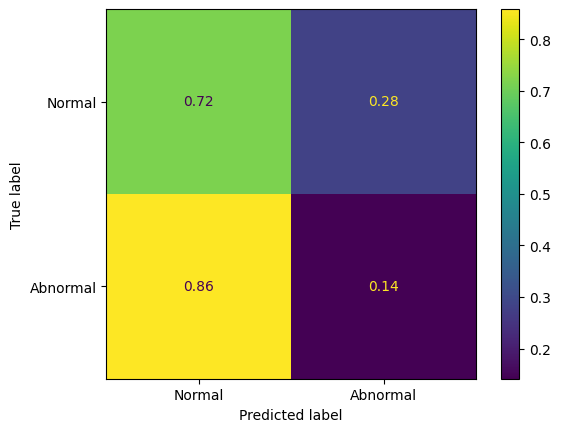

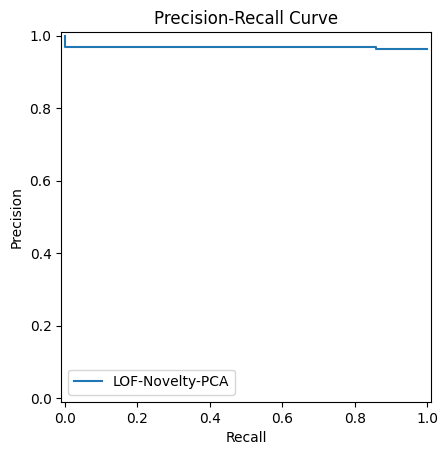

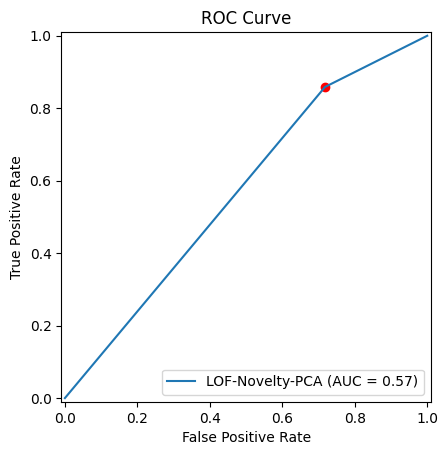

In [27]:
from sklearn import metrics

metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, normalize= 'true', labels=[1, -1],  display_labels=['Normal', 'Abnormal'])

print("Average Accuracy Score:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
print("Balanced Accuracy Score:",metrics.balanced_accuracy_score(Y_test, Y_pred)) # balanced Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, pos_label= -1, average = 'binary'),
                        'Recall': metrics.recall_score(Y_test, Y_pred, pos_label= -1,average = 'binary'),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, pos_label= -1, average = 'binary')},
                        index=['Anomaly'])
                        
print(df_metric)


#Precision-Recall Curve
prec, recall, thresh = metrics.precision_recall_curve(Y_test, Y_pred, pos_label= -1)
pr_display = metrics.PrecisionRecallDisplay(precision=prec, recall=recall, estimator_name='LOF-Novelty-PCA').plot()
plt.title('Precision-Recall Curve')

fpr, tpr, thresh = metrics.roc_curve(Y_test, Y_pred, pos_label= -1)
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name= 'LOF-Novelty-PCA')

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
roc_display.plot()
plt.scatter(best_fpr, best_tpr, c = 'red')
plt.title("ROC Curve")
plt.show()


## Conclusion

The LOF have better result from normalised than standardised dataset. After SMOTE Oversampling the classification result improved.<br>

The result of LOF for Novelty detection have a very good classification result even after PCA. THe ROC Curve doesnt seem to reflect the result of the classification ???<br>

The LOF doesnt seem to produce a good result for Outlier detection.